In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mriqa_dataset import MRIQADataset, simulate_artefacts
import torch

dataset = MRIQADataset(
    '.',    # path to save data to
    modalities=(['T1', 'T2']),
    download=False,
)

def load_data():
    subject = dataset.subjects[0]
    sample = dataset._get_sample_dict_from_subject(subject)
    x = sample['T1'].data
    x = x[0]
    x -= torch.min(x)
    x /= torch.max(x)

    return x

def augment(patient, settings):
    af = simulate_artefacts(patient.reshape(1, 256, 256, 150), artefacts=settings) 
    return af

sample = load_data()

af_eins = augment(sample, (1,0,0,0))
af_zwei = augment(sample, (0,1,0,0))
af_drei = augment(sample, (0,0,1,0))
af_vier = augment(sample, (0,0,0,1))

In [19]:
import torch_optimizer as optim
from networks import CatNet
import torch

model = CatNet(num_classes=5)

optimizer = optim.Ranger(
    model.parameters(),
    lr=1e-3,
    alpha=0.5,
    k=6,
    N_sma_threshhold=5,
    betas=(.95, 0.999),
    eps=1e-5,
    weight_decay=0
)

checkpoint = torch.load("checkpoint_best")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
model.cuda()

CatNet(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): mish_layer()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): skip_connection_block(
    (conv_il): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (batn_il): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_ol): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (batn_ol): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_sl): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
    (batn_sl): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): skip_connection_block(
    (conv_il): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (batn_il): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

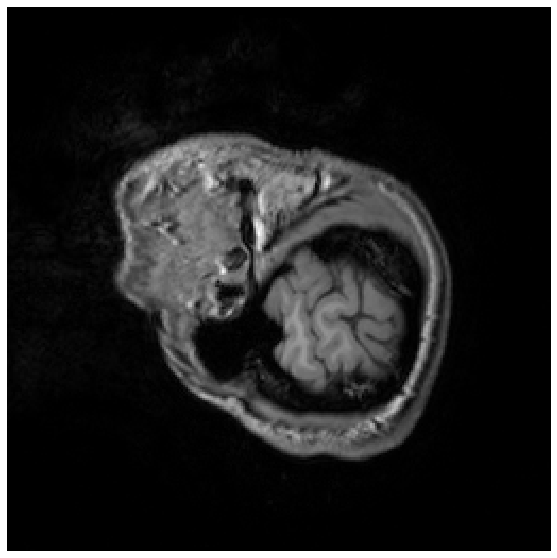

RandomMotion:	0.05612963632019427
RandomGhosting:	0.15709981563366046
RandomBlur:	0.10725717907643904
RandomNoise:	0.025454945939594856
Normal	:	0.6540584230301114


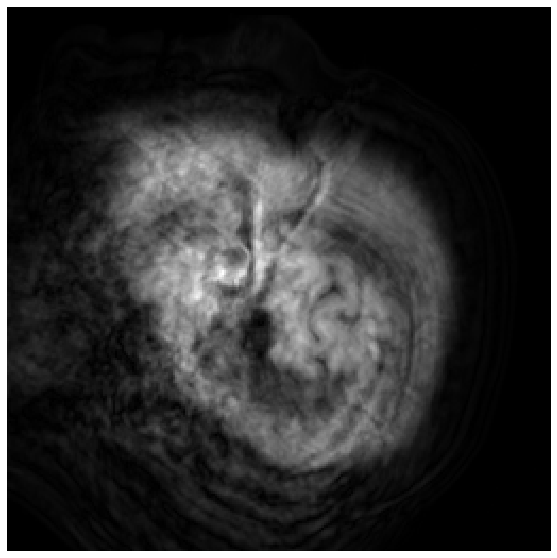

RandomMotion:	0.7425435813458915
RandomGhosting:	0.25555285736697486
RandomBlur:	0.0005447475830695967
RandomNoise:	0.0006842841638797132
Normal	:	0.0006745295401842563


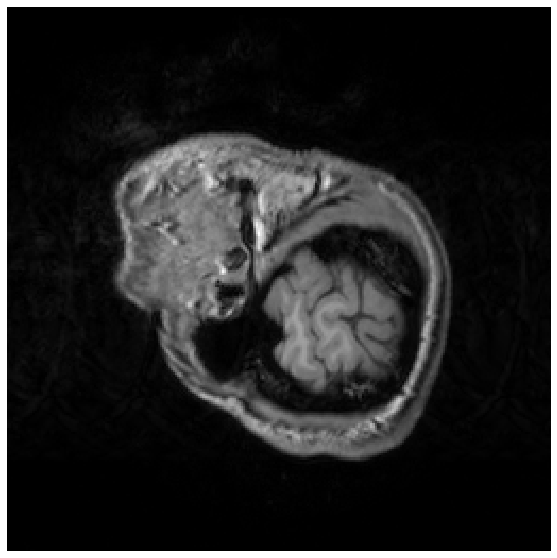

RandomMotion:	0.46746411551591266
RandomGhosting:	0.4750996447661971
RandomBlur:	0.020786807153949562
RandomNoise:	0.015318251270487828
Normal	:	0.02133118129345276


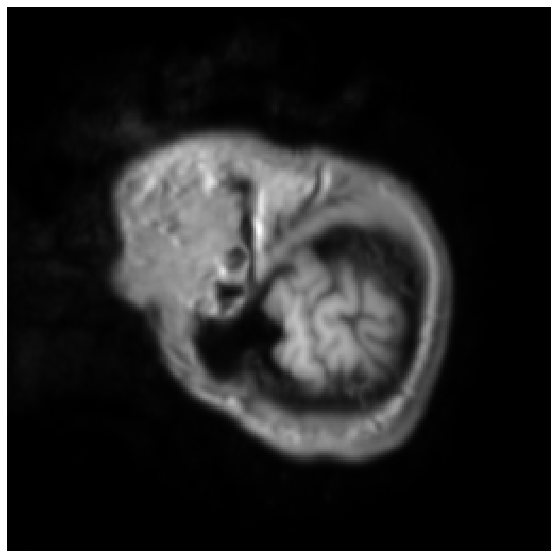

RandomMotion:	0.332011099808899
RandomGhosting:	0.047509768457491046
RandomBlur:	0.5834285575293312
RandomNoise:	0.017531821190996815
Normal	:	0.019518753013282247


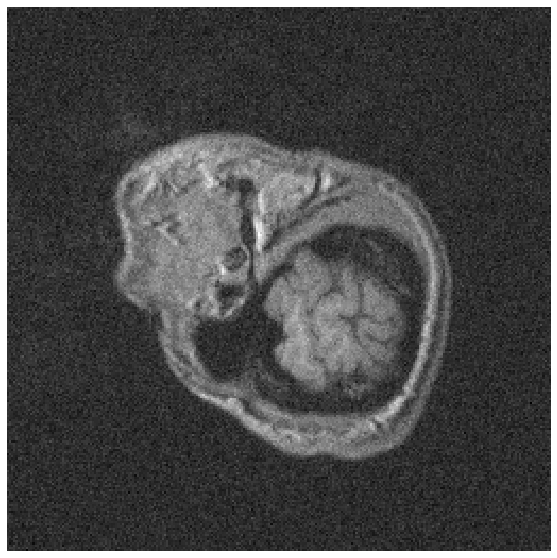

RandomMotion:	0.0009167189741069947
RandomGhosting:	0.0010974871044185984
RandomBlur:	0.0037090974842203623
RandomNoise:	0.9932980089728836
Normal	:	0.0009786874643709447


In [42]:
from scipy.special import softmax
z = 130
classes = ["RandomMotion", "RandomGhosting", "RandomBlur", "RandomNoise", "Normal\t"]

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sample[:,:,z], cmap="gray")
plt.show()

x = sample[:,:,z].reshape(1,1, 256,256).cuda()
p = model(x)
p = softmax(p.cpu().tolist())

for p_, l_ in zip(p[0], classes):
    print(f"{l_}:\t{p_}")

def plot_img(data):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(data, cmap="gray")
    plt.show()   

    x = data.reshape(1,1, 256,256).cuda()
    p = model(x)
    p = softmax(p.cpu().tolist())

    for p_, l_ in zip(p[0], classes):
        print(f"{l_}:\t{p_}")
        
plot_img(af_eins[0,:,:,z])
plot_img(af_zwei[0,:,:,z])
plot_img(af_drei[0,:,:,z])
plot_img(af_vier[0,:,:,z])